# Training Digital Auditing

## Code Workshop: mastering the AI assistant

In [1]:
# Initiate Google Drive connection
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pandas as pd
import os


In [3]:
# Read in your dataset with journal entries
gl_data = pd.read_excel("/content/drive/MyDrive/NBADataScience/Audit cases/DigiJazz_transactions.xlsx", sheet_name="GLData")

# Disable scientific notation, and enable thousand separator
pd.options.display.float_format = '{:,.2f}'.format

gl_data.head(5)

,Date,Period,Description,JournalCode,JournalDesc,JournalType,Booknr,AccountCode,AccountDesc,AccountType,Debit/Credit,Amount,Product ID,User,Relation_id,Relation_name,Source_id,Account
0,2024-04-26,2024-04,Digijazz.nl Order - Mp3603,SJ,Sales Journal,Sales,SJ079206,8000,Revenue digital music,Revenue,Credit,9.00,"1,000.00",MagentoImporter,CUST000259,Kim van der Meer,MAG#446945,8000 Revenue digital music
1,2024-10-09,2024-10,iDEAL Payment Received for #SJ077467,CJ,Cash Journal,Cash,CJ080560,1101,Bank account *313,Asset,Debit,28.98,NaN,MagentoImporter,NaN,NaN,MAG#445206,1101 Bank account *313
2,2024-12-28,2024-12,Digijazz.nl Order - Mp3556,SJ,Sales Journal,Sales,SJ053087,1300,Debtors,Asset,Debit,24.08,NaN,MagentoImporter,CUST000228,Aisha Aït El Hadi,MAG#420826,1300 Debtors
3,2024-03-24,2024-03,Digijazz.nl Order - Vinyl,CO,Automated Article Journal,Purchases,CO035443,1200,Inventory Vinyl,Asset,Credit,31.74,"2,000.00",MagentoImporter,CUST000218,Willem van der Linden,MAG#403182,1200 Inventory Vinyl
4,2024-08-12,2024-08,iDEAL Payment Received for #SJ092001,CJ,Cash Journal,Cash,CJ095094,1101,Bank account *313,Asset,Debit,90.14,NaN,MagentoImporter,NaN,NaN,MAG#459740,1101 Bank account *313


We hebben de volgende kolommen in onze dataset:

In [4]:
gl_data.columns

Index(['Date', 'Period', 'Description', 'JournalCode', 'JournalDesc',
       'JournalType', 'Booknr', 'AccountCode', 'AccountDesc', 'AccountType',
       'Debit/Credit', 'Amount', 'Product ID', 'User', 'Relation_id',
       'Relation_name', 'Source_id', 'Account'],
      dtype='object')

### Maak een 'AmountNet' kolom

In [5]:
# Set AmountNet to 1x the Amount for Debit transactions
gl_data.loc[gl_data['Debit/Credit'] == 'Debit', 'AmountNet'] = gl_data['Amount']
# Set AmountNet to 1x the Amount for Credit transactions
gl_data.loc[gl_data['Debit/Credit'] != 'Debit', 'AmountNet'] = gl_data['Amount'] * -1

### Q1. Maak een Trial Balance om aan te sluiten op het dossier:

In [6]:
gl_data.groupby('Account')['AmountNet'].sum().reset_index()

,Account,AmountNet
0,1101 Bank account *313,"2,231,190.71"
1,1200 Inventory Vinyl,"-1,799,568.72"
2,1300 Debtors,-41.93
3,1500 VAT Payable,"-729,483.63"
4,1520 VAT Recoverable,"239,210.00"
5,1600 Creditors,"37,035.73"
6,1670 Net wages,0.00
7,1780 Payable reservation for vacation allowance,"-28,800.00"
8,1910 Accruals Payable,-0.04
9,1950 Payroll taxes payable,0.00


In [7]:
##

# Revenue analysis

### Exploration

GL/Journal matrix, analyzing the Journals posting on revenue:

In [8]:
df_revenue = gl_data[gl_data['AccountType'] == 'Revenue']

# Create a GL/Journal matrix
df_revenue.pivot_table(index='Account', columns='JournalDesc', values='AmountNet', aggfunc='sum')

JournalDesc,Sales Journal
Account,
8000 Revenue digital music,"-710,329.92"
8001 Revenue Vinyl,"-2,763,854.09"


GL/Journal matrix, analyzing the GL accounts posting using the sales journal:

In [9]:
df_revenue_journal = gl_data[gl_data['JournalType'] == 'Sales']

# Create a GL/Journal matrix
df_revenue_journal.pivot_table(index='Account', columns='JournalDesc', values='AmountNet', aggfunc='sum')

JournalDesc,Sales Journal
Account,
1300 Debtors,"4,203,667.64"
1500 VAT Payable,"-729,483.63"
8000 Revenue digital music,"-710,329.92"
8001 Revenue Vinyl,"-2,763,854.09"


Plot of revenue over time:

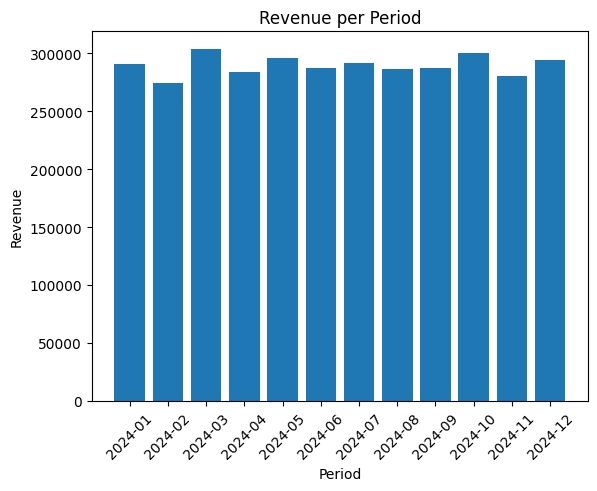

In [ ]:
import matplotlib.pyplot as plt

data = df_revenue.groupby('Period')['Amount'].sum()
x = data.index
y = data.values

# Create a bar chart
plt.bar(x, y)

# Add labels and a title
plt.xlabel('Period')
plt.ylabel('Revenue')
plt.title('Revenue per Period')
plt.xticks(rotation=45) # Rotate the x-axis labels

# Show the plot
plt.show()

### Reconcile Revenue to Sales Journal

In [11]:
# Create a pivot table
df_revenue.pivot_table(index='User', columns='JournalDesc', values='AmountNet', aggfunc='sum')

JournalDesc,Sales Journal
User,
MagentoImporter,"-3,466,523.83"
sysadmin,"-7,660.18"


### Risk analysis: understanding

In [12]:
# Mean transaction amount
df_revenue['Amount'].mean()

np.float64(37.776830676554376)

In [13]:
# Max transaction amount
df_revenue['Amount'].max()

139.9

In [14]:
# Groupby, sum and make sure no scientific notation is used
df_revenue.groupby('User')['Amount'].sum().apply(lambda x: '%.0f' % x).reset_index()

,User,Amount
0,MagentoImporter,3466524
1,sysadmin,7660


### Margin analysis

In [15]:
# Calculate margin per order (using the 'Source_id' column)
salmargin = gl_data[(gl_data['AccountType'] == 'Revenue') | (gl_data['AccountType'] == 'COGS')]
salmargin = salmargin.pivot_table(index='Source_id', columns='AccountType', values='AmountNet', aggfunc='sum').fillna(0).round(2)
salmargin['Margin'] = (-salmargin['Revenue'] - salmargin['COGS'])/(-salmargin['Revenue'])
salmargin['Margin%'] = (-salmargin['Revenue'] - salmargin['COGS'])/(-salmargin['Revenue'])*100

salmargin.head(5)

AccountType,COGS,Revenue,Margin,Margin%
Source_id,,,,
MAG#367741,25.70,-47.00,0.45,45.32
MAG#367742,39.41,-54.50,0.28,27.69
MAG#367743,9.05,-13.50,0.33,32.96
MAG#367744,11.23,-17.90,0.37,37.26
MAG#367745,3.22,-6.00,0.46,46.33


In [16]:
salmargin_negative = salmargin[salmargin['Margin%'] < 0]
salmargin_negative.head(5)

AccountType,COGS,Revenue,Margin,Margin%
Source_id,,,,
MAG#367950,45.26,-35.70,-0.27,-26.78
MAG#368770,17.76,-12.38,-0.43,-43.46
MAG#368794,8.85,-7.12,-0.24,-24.30
MAG#368880,49.05,-37.95,-0.29,-29.25
MAG#369091,37.81,-32.18,-0.17,-17.50


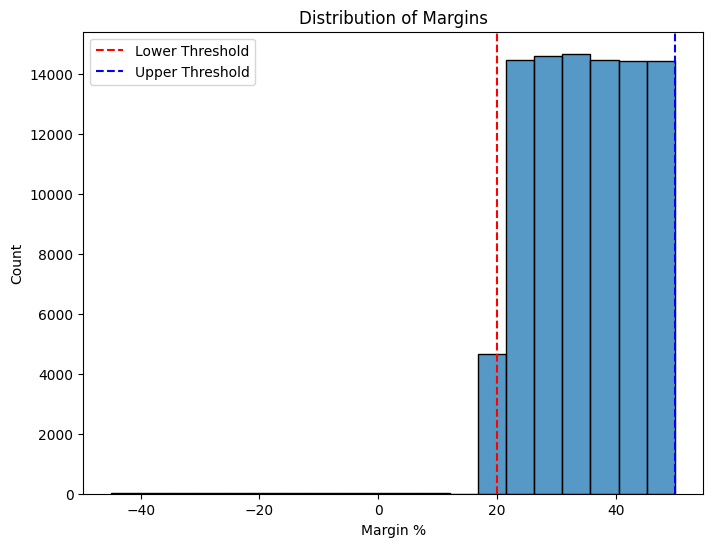

In [17]:
# We use the pyplot and seaborn libraries to visualize the data, refer to Cheatsheet Week 1a - Libraries and Exploring a dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing transaction values for outliers
# Define thresholds based on typical transaction ranges
threshold_lower = 20 # Assumed min 20% margin based on knowledge from DigiJazz
threshold_upper = 50 # Assumed max 50% margin based on knowledge from DigiJazz

# Plot histogram for transaction values
plt.figure(figsize=(8, 6))
sns.histplot(salmargin['Margin%'], bins=20)
plt.axvline(threshold_lower, color='red', linestyle='--', label='Lower Threshold')
plt.axvline(threshold_upper, color='blue', linestyle='--', label='Upper Threshold')
plt.title('Distribution of Margins')
plt.xlabel('Margin %')
plt.legend()
plt.show()

In [40]:
# prompt: Help me identify fraudulent orders. Find patterns in the data and identify outliers based on the patterns. consider using classification or other algoritms

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Focus on the transaction-level data relevant to potential fraud
# We can use the 'salmargin' DataFrame created earlier, which has order-level margin data
# Let's also include the 'Amount' from the original gl_data if possible for richer features.
# We need to aggregate gl_data by Source_id to merge with salmargin

# Aggregate the total transaction amount per Source_id from the original data
transaction_amounts = gl_data.groupby('Source_id')['Amount'].sum().reset_index()
transaction_amounts.rename(columns={'Amount': 'TotalAmount'}, inplace=True)

# Merge the total amount with the margin data
salmargin_fraud = pd.merge(salmargin, transaction_amounts, on='Source_id', how='left')

# Select features for anomaly detection
features = salmargin_fraud[[ 'Margin%', 'TotalAmount']] #'Margin',

# Handle potential infinite values that might arise from margin calculation if Revenue is 0
features.replace([float('inf'), float('-inf')], 0, inplace=True)
features.fillna(0, inplace=True) # Handle any remaining NaNs

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply Isolation Forest
# n_estimators: The number of base estimators in the ensemble.
# contamination: The proportion of outliers in the data set. This needs to be estimated or can be set to 'auto'.
# random_state: for reproducibility
model = IsolationForest(n_estimators=300, contamination=0.0085, random_state=42)
model.fit(scaled_features)

# Predict anomalies (-1 for outliers, 1 for inliers)
salmargin_fraud['anomaly_score'] = model.decision_function(scaled_features)
salmargin_fraud['is_outlier'] = model.predict(scaled_features)


# # You can also examine the original transactions for these Source_id values
# print("\nExample transactions for a potential fraudulent order (Source_id):")
# if not fraudulent_orders.empty:
#     example_source_id = fraudulent_orders.iloc[0]['Source_id']
#     print(gl_data[gl_data['Source_id'] == example_source_id])


<ipython-input-40-fb001d2156c2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.replace([float('inf'), float('-inf')], 0, inplace=True)
<ipython-input-40-fb001d2156c2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace=True) # Handle any remaining NaNs


In [41]:
# Filter out the identified fraudulent/anomalous orders
fraudulent_orders = salmargin_fraud[salmargin_fraud['is_outlier'] == -1]

print("Identified Potential Fraudulent Orders:")
fraudulent_orders

Identified Potential Fraudulent Orders:


,Source_id,COGS,Revenue,Margin,Margin%,TotalAmount,anomaly_score,is_outlier
41,MAG#367786,1.19,-1.50,0.21,20.67,9.64,-0.00,-1
160,MAG#367950,45.26,-35.70,-0.27,-26.78,263.32,-0.07,-1
262,MAG#368085,100.35,-137.00,0.27,26.75,863.78,-0.02,-1
517,MAG#368437,57.59,-72.50,0.21,20.57,466.06,-0.00,-1
557,MAG#368489,15.69,-15.95,0.02,1.63,108.58,-0.01,-1
...,...,...,...,...,...,...,...,...
91591,MAG#489850,37.70,-74.90,0.50,49.67,437.92,-0.00,-1
91600,MAG#489861,0.80,-1.00,0.20,20.00,6.44,-0.02,-1
91768,MAG#490083,38.31,-39.88,0.04,3.94,269.62,-0.03,-1
91871,MAG#490212,57.79,-73.00,0.21,20.84,468.90,-0.00,-1


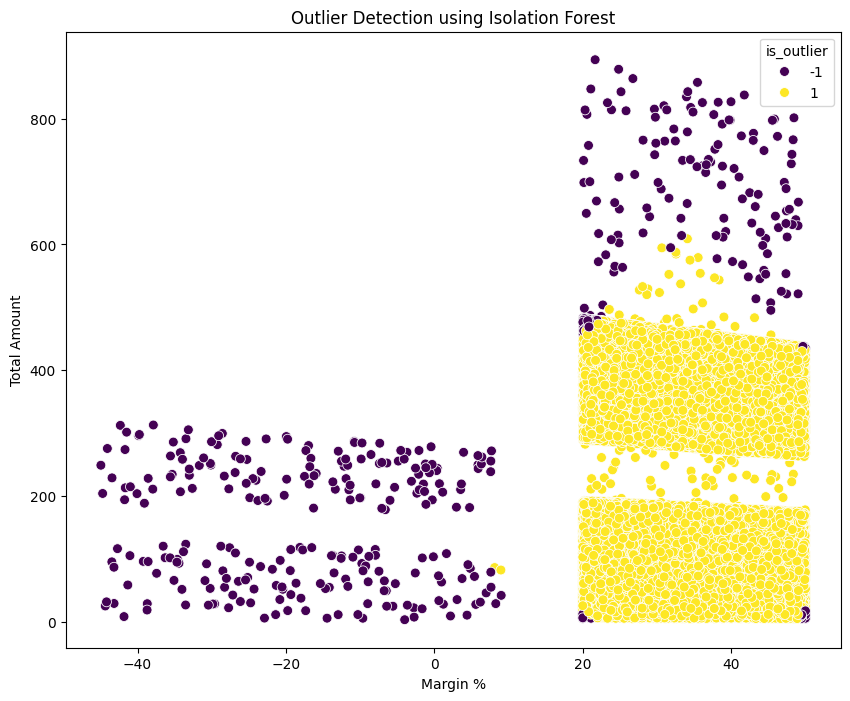

In [42]:
# Visualize the outliers based on two features (e.g., Margin% and TotalAmount)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=salmargin_fraud, x='Margin%', y='TotalAmount', hue='is_outlier', palette='viridis', s=50)
plt.title('Outlier Detection using Isolation Forest')
plt.xlabel('Margin %')
plt.ylabel('Total Amount')
plt.show()

In [43]:
salmargin_fraud

,Source_id,COGS,Revenue,Margin,Margin%,TotalAmount,anomaly_score,is_outlier
0,MAG#367741,25.70,-47.00,0.45,45.32,278.88,0.09,1
1,MAG#367742,39.41,-54.50,0.28,27.69,342.60,0.13,1
2,MAG#367743,9.05,-13.50,0.33,32.96,83.44,0.13,1
3,MAG#367744,11.23,-17.90,0.37,37.26,109.10,0.14,1
4,MAG#367745,3.22,-6.00,0.46,46.33,35.48,0.08,1
...,...,...,...,...,...,...,...,...
91961,MAG#490346,30.41,-53.00,0.43,42.62,317.34,0.12,1
91962,MAG#490347,44.56,-62.50,0.29,28.70,391.60,0.12,1
91963,MAG#490348,5.97,-9.00,0.34,33.67,55.50,0.12,1
91964,MAG#490349,24.88,-48.90,0.49,49.12,286.44,0.05,1


In [44]:
# Further analysis of fraudulent orders: e.g., by User, JournalDesc
print("\nAnalysis of Fraudulent Orders by User:")
merged_fraud_data = pd.merge(fraudulent_orders, gl_data[['Source_id', 'User', 'JournalDesc']].drop_duplicates(), on='Source_id', how='left')
merged_fraud_data.groupby(['User', 'JournalDesc']).size().reset_index(name='fraudulent_count')


Analysis of Fraudulent Orders by User:


,User,JournalDesc,fraudulent_count
0,MagentoImporter,Automated Article Journal,528
1,MagentoImporter,Cash Journal,528
2,MagentoImporter,Sales Journal,528
3,sysadmin,Automated Article Journal,253
4,sysadmin,Cash Journal,253
5,sysadmin,Sales Journal,253


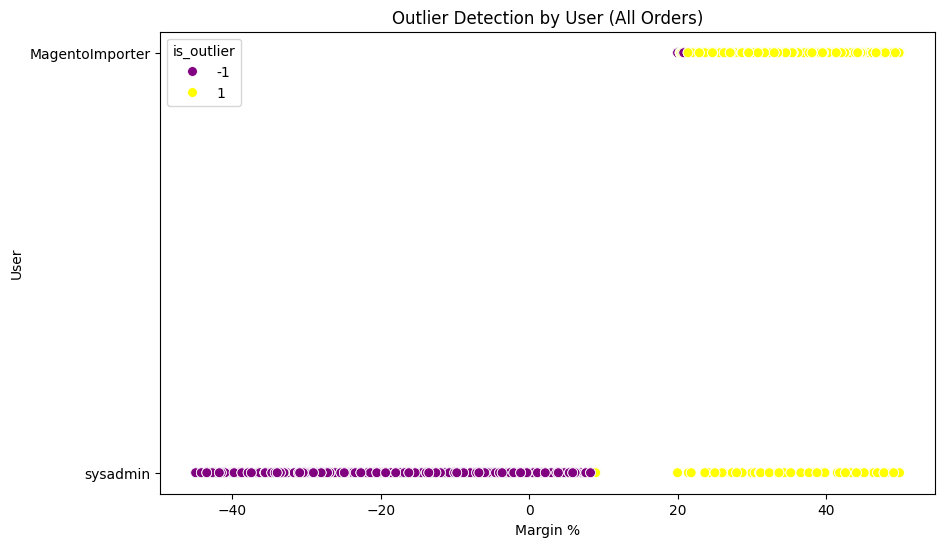

In [46]:
# Merge user and journal info into full salmargin_fraud dataset
salmargin_fraud_with_user = pd.merge(
    salmargin_fraud,
    gl_data[['Source_id', 'User', 'JournalDesc']].drop_duplicates(),
    on='Source_id',
    how='left'
)

import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'User' to string and fill missing values
salmargin_fraud_with_user['User'] = salmargin_fraud_with_user['User'].astype(str).fillna('Unknown')

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=salmargin_fraud_with_user,
    x='Margin%',
    y='User',
    hue='is_outlier',
    palette={-1: 'purple', 1: 'yellow'},
    s=50
)

plt.title('Outlier Detection by User (All Orders)')
plt.xlabel('Margin %')
plt.ylabel('User')
plt.legend(title='is_outlier')
#plt.tight_layout()
plt.show()